In [34]:
# help functions from https://github.com/dalab/lecture_cil_public/blob/master/exercises/2019/ex11_old/segment_aerial_images.ipynb
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import re
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import sklearn.model_selection as sk
from tensorflow.keras.models import load_model

In [23]:
print(tf.__version__)

2.1.0


In [24]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [25]:
def img_crop_64(im, w, h):
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    im_padded = np.pad(im, ((64,64),(64,64), (0,0)), 'constant')
    im = im_padded
    list_patches = []
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[64+j-24:64+j+w+24, 64+i-24:64+i+h+24]
            else:
                im_patch = im[64+j-24:64+j+w+24, 64+i-24:64+i+h+24, :]
#                 print("3d", i, j, im_patch.shape)
            list_patches.append(im_patch)
    return list_patches
# A = 

# print(imgs[1].shape)
# b = img_crop(imgs[1], 16,16)
# a = img_crop_64(imgs[1], 16,16)
# print(b[0].shape)
# print(a[0].shape)
# print(imgs[1].shape)

In [26]:
# Convert array of labels to an image

def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img

In [60]:
# Loaded a set of images
repo_dir = "../../"
data_dir = repo_dir + "data/"
training_dir = data_dir + "training/"
test_dir = data_dir + "test_images/"

image_dir = training_dir + "images/"
image_dir_orig = training_dir + "images_pix_256/"
files = os.listdir(image_dir)
n = len(files) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
train_imgs_idx = files;
print(files[0])

gt_dir = training_dir + "groundtruth/"
print("Loading " + str(n) + " gt images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

# n = 10 # Only use 10 images for training


Loading 100 images
satImage_052.png
Loading 100 gt images
satImage_052.png


In [28]:
# transform to 400x400
# files = os.listdir(image_dir_orig)
# n = len(files)
# imgs = [(files[i], load_image(image_dir_orig + files[i])) for i in range(n)]
# for name, f in imgs:
#     save_path = image_dir + name
#     image = tf.image.resize(f, size=(400,400), method=tf.image.ResizeMethod.BICUBIC)
#     tf.keras.preprocessing.image.save_img(save_path,image)

In [8]:
files = os.listdir(test_dir)
print("Loading " + str(len(files)) + " test images")
files
test_imgs = [load_image(test_dir + f) for f in files]
test_imgs_idx = files;

Loading 94 test images


In [9]:
test_imgs_idx[0]

'test_205.png'

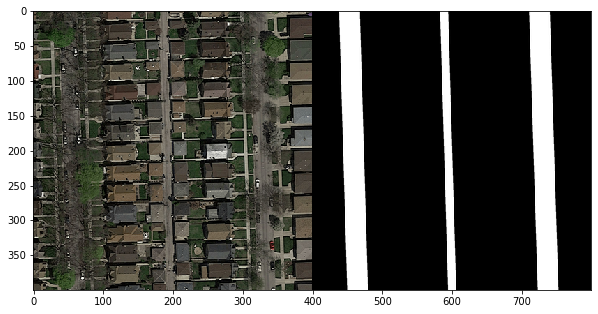

In [10]:
# Show first image and its groundtruth image
cimg = concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

In [11]:
# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

img_patches = [img_crop_64(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

test_patches = [img_crop_64(test_imgs[i], patch_size, patch_size) for i in range(len(test_imgs))]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])
test_patches =  np.asarray([test_patches[i][j] for i in range(len(test_patches)) for j in range(len(test_patches[i]))])

In [12]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0

# X = np.asarray([ extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
# Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])
X = np.asarray([ img_patches[i] for i in range(len(img_patches))])
Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

In [13]:
X.shape, Y.shape

((62500, 64, 64, 3), (62500,))

In [79]:
indices = np.arange(X.shape[0])

In [80]:
X_train, X_test, y_train, y_test, indices_train, indices_test = sk.train_test_split(X,Y,indices,test_size=0.20, random_state = 42)

In [86]:
min(indices_test)

4

In [82]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, indices_train.shape, indices_test.shape

((50000, 64, 64, 3),
 (12500, 64, 64, 3),
 (50000,),
 (12500,),
 (50000,),
 (12500,))

In [16]:
model = Sequential([
#     Conv2D(16, 3, padding='same', activation='relu', input_shape=(patch_size, patch_size, 3)),
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
#     Dense(512, activation='relu'),
#     Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1)
])

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

In [19]:
log_dir="logs/fit"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
filepath="weights/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [85]:
model.fit(X_train,
          y_train,
          epochs=100,
          shuffle=True,
          validation_data=(X_test, y_test),
          callbacks=[
                keras.callbacks.EarlyStopping(
                    patience=5,
                    restore_best_weights=True,
                ),
                tensorboard_callback,
#                 checkpoint
          ])

Train on 50000 samples, validate on 12500 samples
Epoch 1/100
12928/50000 [======>.......................] - ETA: 2:01 - loss: 0.5882 - accuracy: 0.7381

KeyboardInterrupt: 

In [73]:
# model.save('my_model.h5')

In [122]:
# model = load_model('my_model3.h5')

In [123]:
test_patches.shape

(135736, 64, 64, 3)

In [124]:
prediction = model.predict(test_patches)
print(min(prediction), max(prediction))
prediction = (np.sign(prediction)+1)/2
print(min(prediction), max(prediction))

[-16.541784] [19.245565]
[0.] [1.]


In [125]:
prediction_train = model.predict(img_patches)
prediction_train = (np.sign(prediction_train)+1)/2

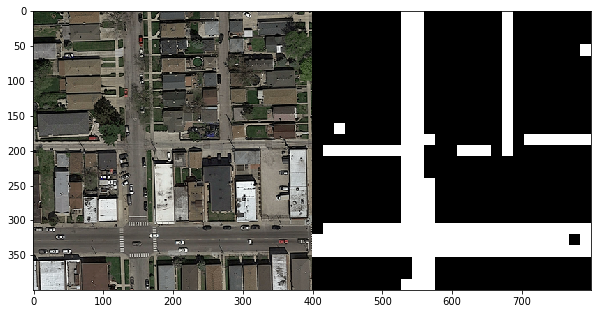

In [126]:
# # Display prediction as an image
img_idx = 13
w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
patches_per_image = int(w*h/16/16)
fr = patches_per_image*img_idx
to = patches_per_image*(img_idx+1)
labels = prediction_train[fr:to+1]
predicted_im = label_to_img(w, h, patch_size, patch_size, labels)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
# plt.imshow(predicted_img, cmap='Greys_r')
plt.imshow(cimg, cmap='Greys_r')
# plt.imshow(overlay)

In [127]:
result_dir = repo_dir + "code/patch_based/results/"
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

In [128]:
def create_res_dirs(result_dir):
    prediction_dir = result_dir + "prediction/"
    concat_dir = result_dir + "concat/"
    overlay_dir = result_dir + "overlay/"
    for dr in [result_dir, prediction_dir, concat_dir, overlay_dir]:    
        if not os.path.exists(dr):
            os.makedirs(dr)

In [129]:
create_res_dirs(result_dir + "test/")
create_res_dirs(result_dir + "train/")
create_res_dirs(result_dir + "val/")

In [130]:
def eval_f(test_imgs, test_imgs_idx, prediction, result_dir, train=False, result_dir_val=""):
    result_dir_backup = result_dir
    for (i, name) in enumerate(test_imgs_idx):
        if train:
            if i in indices_test:
                result_dir = result_dir_val
            else:
                result_dir = result_dir_backup
        w = test_imgs[i].shape[0]
        h = test_imgs[i].shape[1]
        patches_per_image = int(w*h/16/16)
        fr = patches_per_image*i
        to = patches_per_image*(i+1)
        labels = prediction[fr:to+1]
        predicted_img = label_to_img(w, h, patch_size, patch_size, labels)
        original_img = test_imgs[i]
        overlay = make_img_overlay(original_img, predicted_img)
        cimg = concatenate_images(original_img, predicted_img)

        img_number = int(re.search(r"\d+", test_imgs_idx[i]).group(0))

        predicted_img = img_float_to_uint8(predicted_img)
        cimg = img_float_to_uint8(cimg)
        prediction_dir = result_dir + "prediction/"
        concat_dir = result_dir + "concat/"
        overlay_dir = result_dir + "overlay/"
        Image.fromarray(predicted_img).save(prediction_dir + "prediction_" + str(img_number) + ".png")
        Image.fromarray(cimg).save(concat_dir + "concat_" + str(img_number) + ".png")
        overlay.save(overlay_dir + "overlay_" + str(img_number) + ".png")

    #     fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
    #     plt.imshow(predicted_img, cmap='Greys_r')
    #     plt.imshow(cimg, cmap='Greys_r')
    #     plt.imshow(overlay)
    #     break

In [131]:
eval_f(test_imgs, test_imgs_idx, prediction, result_dir + "test/")

In [132]:
eval_f(imgs, train_imgs_idx, prediction_train, result_dir + "train/", True, result_dir + "val/")

/Users/msladek/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [98]:
# imgs[i].shape

TypeError: resize_images_v2() missing 2 required positional arguments: 'images' and 'size'